In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import KNNImputer

from imblearn.over_sampling import SMOTE
from category_encoders import TargetEncoder

from scipy.stats import ttest_ind, chi2_contingency, levene, shapiro, f_oneway

# Load data

In [3]:
data = pd.read_csv('DBS.csv', sep=';')
test = pd.read_csv('DBS_2020.csv', sep=';')

In [4]:
data['label'] = data['graduate'].apply(lambda x: 0 if x==1 else (1 if x==0 else x))
test['label'] = test['graduate'].apply(lambda x: 0 if x==1 else (1 if x==0 else x))

In [5]:
drop_list = ['result_grade', 'year', 'acad_year', 'graduate']
df = data.drop(drop_list, axis=1)
test1 = test.drop(drop_list, axis=1).copy()

In [6]:
str_cols = df.select_dtypes(object).columns
num_cols = df.select_dtypes(np.number).columns

In [7]:
for col in str_cols:
    print(col, np.unique(df[col]))

tests_grade ['0' 'A' 'B' 'C' 'D' 'E' 'FX']
project_grade ['0' 'A' 'B' 'C' 'D' 'E' 'FX']


In [8]:
df[df['tests_grade']=='0']

,access,tests,tests_grade,exam,project,project_grade,assignments,result_points,label
260,28,0.0,0,0,0.0,0,0.0,0.0,1


In [9]:
for col in str_cols:
    df[col] = df[col].apply(lambda x: 'FX' if x=='0' else x)

# EDA

In [11]:
df['label'].value_counts()

0    210
1     51
Name: label, dtype: int64

In [45]:
print(str_cols.tolist())

['tests_grade', 'project_grade']


## Missing values

In [12]:
df.isna().sum()

access           0
tests            0
tests_grade      0
exam             0
project          0
project_grade    0
assignments      0
result_points    0
label            0
dtype: int64

In [13]:
test.isna().sum()

access           0
tests            0
tests_grade      0
exam             0
project          0
project_grade    0
assignments      0
result_points    0
result_grade     0
graduate         0
year             0
acad_year        0
label            0
dtype: int64

## Test statistic

### Numeric

In [12]:
for col in num_cols[:-1]:
    a = df[df['label']==1][col]
    b = df[df['label']==0][col]
    if levene(a, b)[1]>=0.05:
        print(col, ttest_ind(a, b, equal_var=True)[1], 'equal_var')
    else:
        print(col, ttest_ind(a, b, equal_var=False)[1])

access 4.744716554965041e-09 equal_var
tests 4.204939069693362e-10
exam 4.5143039429289686e-27
project 7.788532319764319e-22
assignments 7.140735804548953e-10
result_points 2.23660727190255e-25


### Categorical

In [289]:
pd.crosstab(df['tests_grade'], columns=df['label'])

label,0,1
tests_grade,,
A,14,0
B,23,2
C,50,3
D,51,5
E,51,7
FX,21,34


In [290]:
chi2_contingency(pd.crosstab(df['tests_grade'], columns=df['label']))

(80.61132598802814,
 6.250947799285692e-16,
 5,
 array([[11.26436782,  2.73563218],
        [20.11494253,  4.88505747],
        [42.64367816, 10.35632184],
        [45.05747126, 10.94252874],
        [46.66666667, 11.33333333],
        [44.25287356, 10.74712644]]))

In [287]:
pd.crosstab(df['project_grade'], columns=df['label'])

label,0,1
project_grade,,
A,105,1
B,54,1
C,34,1
D,10,1
E,2,5
FX,5,42


In [288]:
chi2_contingency(pd.crosstab(df['project_grade'], columns=df['label']))

(198.98788116056613,
 4.676493242319777e-41,
 5,
 array([[85.28735632, 20.71264368],
        [44.25287356, 10.74712644],
        [28.16091954,  6.83908046],
        [ 8.85057471,  2.14942529],
        [ 5.63218391,  1.36781609],
        [37.81609195,  9.18390805]]))

In [65]:
for col in str_cols:
    print(col, np.unique(df[col]))

tests_grade ['A' 'B' 'C' 'D' 'E' 'FX']
project_grade ['A' 'B' 'C' 'D' 'E' 'FX']


# Preprocessing

In [10]:
for col in str_cols:
    en = OrdinalEncoder(categories=[np.unique(df[col]).tolist()[::-1]],  handle_unknown='use_encoded_value', unknown_value=-1)
    df[col] = en.fit_transform(df[col].values.reshape(-1,1))
    test1[col] = en.transform(test1[col].values.reshape(-1,1))

In [11]:
# en = TargetEncoder()
# df[str_cols] = en.fit_transform(df[str_cols], df['label'])
# test1[str_cols] = en.transform(test1[str_cols])

In [12]:
drop_feats = ['label', ] #'result_points'
X_train, y_train = df.drop(drop_feats, axis=1), df['label']
X_test, y_test = test1.drop(drop_feats, axis=1), test1['label']

feat_names = X_train.columns

In [13]:
pf = PolynomialFeatures(interaction_only=True, include_bias=False, degree=2)
pf.fit(X_train)

X_train = pf.transform(X_train)
X_test = pf.transform(X_test)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [16]:
feat_names_pf = [i.replace(' ', ' * ') for i in pf.get_feature_names(feat_names)]

# Train

## Linear SVC

In [19]:
model_lsv = LinearSVC(dual=False, max_iter=10000, random_state=42)
model_lsv.fit(X_train, y_train)

pred_lsv = model_lsv.predict(X_test)

print(model_lsv.score(X_test, y_test))
print(f1_score(y_test, pred_lsv, ))

0.9666666666666667
0.9333333333333333


In [21]:
rfecv = RFECV(estimator=model_lsv, cv=10, scoring='f1', )
rfecv.fit(X_train, y_train)

print(rfecv.ranking_.tolist())
np.unique(rfecv.support_, return_counts=True)

[7, 4, 1, 1, 1, 1, 1, 5, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 1, 3]


(array([False,  True]), array([ 7, 29], dtype=int64))

In [22]:
model_lsv.fit(rfecv.transform(X_train), y_train)

pred_lsv = model_lsv.predict(rfecv.transform(X_test))

print(model_lsv.score(rfecv.transform(X_test), y_test))
print(f1_score(y_test, pred_lsv))

0.9666666666666667
0.9333333333333333


In [25]:
pd.DataFrame(confusion_matrix(y_test, pred_lsv, labels=[1, 0]), index=['True 1', 'True 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,14,0
True 0,2,44


## Linear Discriminant Analysis

In [21]:
model_ld = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
model_ld.fit(X_train, y_train)

pred_ld = model_ld.predict(X_test)

print(model_ld.score(X_test, y_test))
print(f1_score(y_test, pred_ld, ))

0.9666666666666667
0.9333333333333333


In [22]:
rfecv = RFECV(estimator=model_ld, cv=10, scoring='f1', )
rfecv.fit(X_train, y_train)

rfecv.ranking_

array([ 5,  4,  1,  1,  1,  1,  1, 11,  9,  7,  1,  1,  1,  1,  8,  1,  1,
        1,  1,  2,  3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  6,
        1, 10])

In [23]:
np.unique(rfecv.support_, return_counts=True)

(array([False,  True]), array([10, 26], dtype=int64))

In [24]:
model_ld.fit(rfecv.transform(X_train), y_train)

pred_ld = model_ld.predict(rfecv.transform(X_test))

print(model_ld.score(rfecv.transform(X_test), y_test))
print(f1_score(y_test, pred_ld))

0.9666666666666667
0.9333333333333333


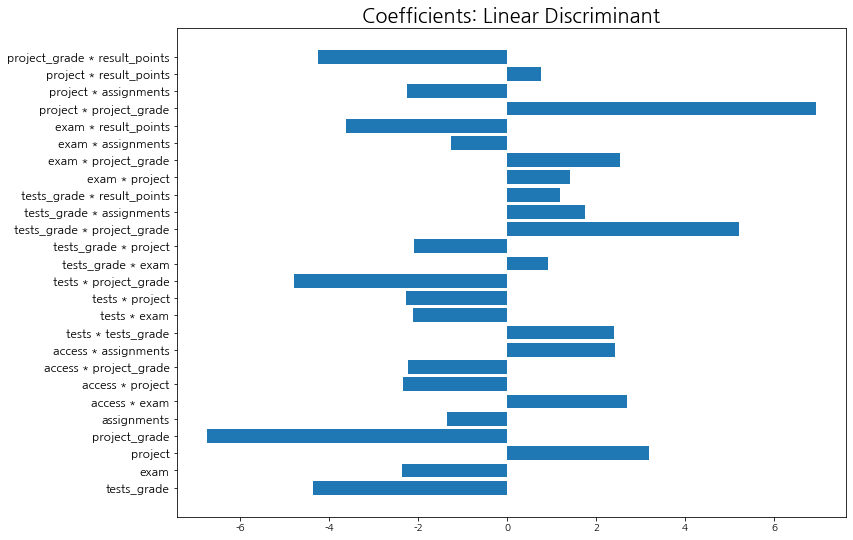

In [27]:
plt.figure(figsize=(12,9))
plt.barh( np.array(feat_names_pf)[np.where(rfecv.support_==True)[0]], model_ld.coef_[0])
plt.yticks(fontsize=12)
plt.title('Coefficients: Linear Discriminant', fontsize=20)
plt.show()

In [33]:
pd.DataFrame(confusion_matrix(y_test, pred_ld, labels=[1, 0]), index=['True 1', 'True 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,14,0
True 0,2,44


## Logistic Regression

In [66]:
model_lr = LogisticRegression(solver='lbfgs', C=1., random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

pred_lr = model_lr.predict(X_test)

print(model_lr.score(X_test, y_test, ))
print(f1_score(y_test, pred_lr, ))
print(roc_auc_score(y_test, model_lr.predict_proba(X_test)[:, 1]))

0.9666666666666667
0.9333333333333333
0.9922360248447205


In [67]:
rfecv = RFECV(estimator=model_lr, cv=10, scoring='f1', )
rfecv.fit(X_train, y_train)

print('ranking:', rfecv.ranking_)
print('support features:', np.unique(rfecv.support_, return_counts=True))

ranking: [ 1  1  1  1  1  1 10  7  9  1  3  1  1  1  1  1  1  6  1  1  1  4  1 11
  1  5  8  1  1  1  1  1  2  1  1  1]
support features: (array([False,  True]), array([10, 26], dtype=int64))


* with selected features only

In [68]:
model_lr = LogisticRegression(solver='lbfgs', C=1., random_state=42)
model_lr.fit(rfecv.transform(X_train), y_train)

pred_lr = model_lr.predict(rfecv.transform(X_test))

print('Acc:',model_lr.score(rfecv.transform(X_test), y_test))
print('F1:',f1_score(y_test, pred_lr))
print('Precision:',precision_score(y_test, pred_lr))
print('Recall:',recall_score(y_test, pred_lr))
print('AUC:',roc_auc_score(y_test, model_lr.predict_proba(rfecv.transform(X_test))[:, 1]))

Acc: 0.9666666666666667
F1: 0.9333333333333333
Precision: 0.875
Recall: 1.0
AUC: 0.9922360248447205


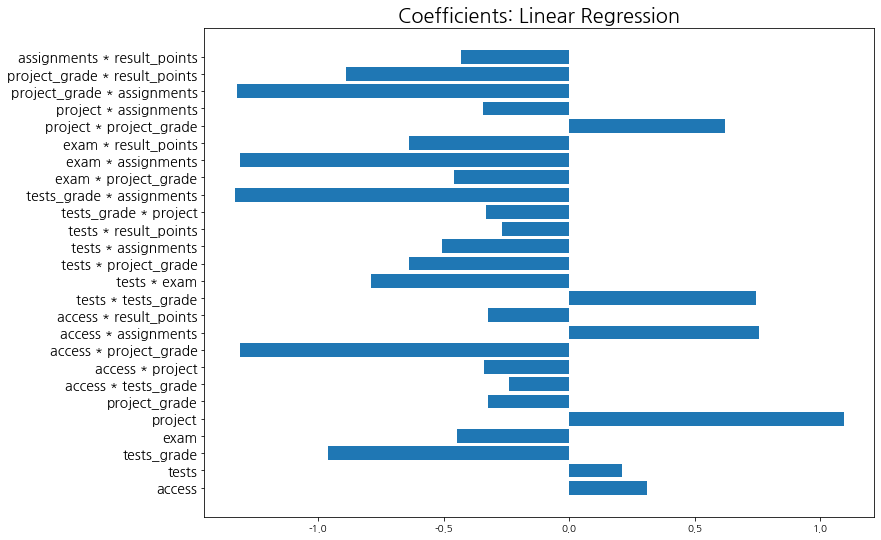

In [70]:
plt.figure(figsize=(12,9))
plt.barh( np.array(feat_names_pf)[np.where(rfecv.support_==True)[0]], model_lr.coef_[0])
plt.yticks(fontsize=14)
plt.title('Coefficients: Linear Regression', fontsize=20)
plt.show()

In [32]:
pd.DataFrame(confusion_matrix(y_test, pred_lr, labels=[1, 0]), index=['True 1', 'True 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,14,0
True 0,2,44


## Random Forest

In [51]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)

pred_rf = model_rf.predict(X_test)

print(model_rf.score(X_test, y_test))
print(f1_score(y_test, pred_rf))
print(roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1]))

0.95
0.896551724137931
0.9953416149068323


In [52]:
rfecv = RFECV(estimator=model_rf, scoring='f1')
rfecv.fit(X_train, y_train)

rfecv.ranking_

array([ 8,  1,  1,  1,  1,  1,  5,  1,  1, 11,  1,  7,  1,  1, 10,  4,  1,
        1,  1,  1,  1,  1, 13, 12,  2,  9,  6,  1,  1,  1,  3,  1,  1,  1,
        1,  1])

In [56]:
np.unique(rfecv.support_, return_counts=True)

(array([False,  True]), array([12, 24], dtype=int64))

In [53]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(rfecv.transform(X_train), y_train)

pred_rf = model_rf.predict(rfecv.transform(X_test))

print(model_rf.score(rfecv.transform(X_test), y_test))
print(f1_score(y_test, pred_rf))
print(roc_auc_score(y_test, model_rf.predict_proba(rfecv.transform(X_test))[:, 1]))

0.95
0.896551724137931
0.9937888198757764


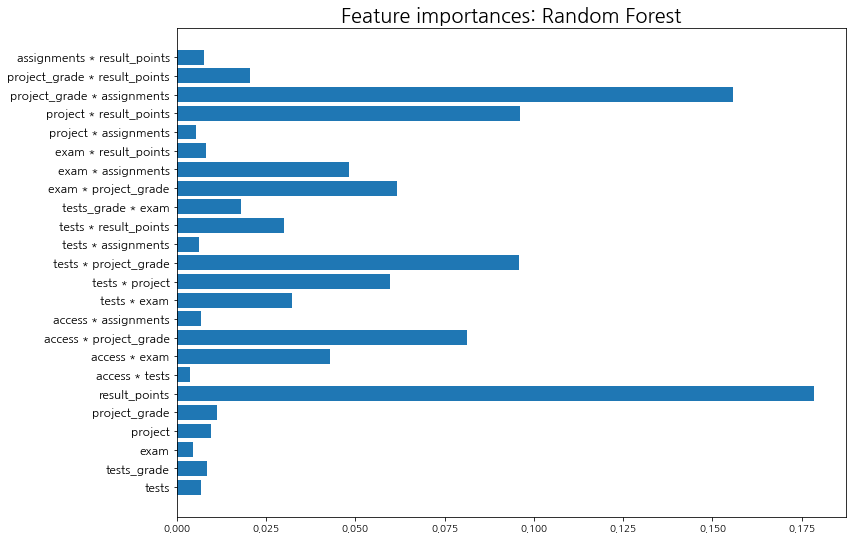

In [37]:
plt.figure(figsize=(12,9))
plt.barh( np.array(feat_names_pf)[np.where(rfecv.support_==True)[0]], model_rf.feature_importances_)
plt.yticks(fontsize=12)
plt.title('Feature importances: Random Forest', fontsize=20)
plt.show()

In [38]:
pd.DataFrame(confusion_matrix(y_test, pred_rf, labels=[1, 0]), index=['True 1', 'True 0'], columns = ['Pred 1', 'Pred 0'])

,Pred 1,Pred 0
True 1,13,1
True 0,2,44
